# Prepping 黑ん防 Data for Classifying 
_Alicia Roberts_

Given data from the Hoji Shinbun Digital Archive for occurences of kuronbou in texts, clean the data to be ready for classifying. 

_goal:_ create a tokenized, shortened, cleaned string of each occurence of nisei in the text as its own data point in a data frame. 

input columns: link, linkWithDate, numWords, paragraphs, pdfName

Given num words, this will add N-1 data points per a data point where N is the value in numWords. 

outputs: 

training matrix: training values for each data point (leave all information up to some lower limit, then perform PCA later)
data matrix: link, year, text (not tokenized) 

**updates:** Having performed clustering on a small 100 text subset, we now have 5000 data points to refer to now! 


Date started: 1/9/2024 

Data recieved from Sora Thomas of UC Berkeley

In [2]:
# working with the output file Sora made:

# data libraries
import pandas as pd
import numpy as np


# NLP Libraries
import re
import fugashi
tagger = fugashi.Tagger()


# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()


In [3]:
data = pd.read_csv('kuron_data.csv')

In [4]:
data.head()

,ArticleLink,Headline,Text,Sentiment
0,https://hojishinbun.hoover.org/?a=d&d=nws19360...,ランドン知事東岸人気 西岸に影響か\n\n市内高校蹴球全星軍 今秋日本遠征の計画 ローエル高...,歎十 05 第\n\n米國名物の私刑事件が二人なんぶ南部に起つた 。 一つはジオジア州の 3...,Negative
1,https://hojishinbun.hoover.org/?a=d&d=tnw19240...,関東侠客国定忠次 桃川如燕講演（九）庚申堂暗夜の争闘蠢きつつ兄分の宅へ\n\n黒ン坊と日本娘...,敗三十六窗ニ離 ー 讲\n\n[ 却\n\n13 一总 ， つ 、 兄分の寒へ ， 2 ； ...,Positive
2,https://hojishinbun.hoover.org/?a=d&d=jan19130...,玉突場業者に警告 オハヨ玉場主人拘引事件\n\n発狂か馬鹿横着か\n\n麥日会負担額相違\n...,8 八十 ， 六零 ：： 霸 ，\n\n蒙四十六西凡千圃爾\n\n擘日は )\n\n1 食料...,Negative
3,https://hojishinbun.hoover.org/?a=d&d=jan19181...,天洋丸で来桑確定せる牧野男以下の講和使節 二十六日着桑特別扱で即刻上陸 一行廿一名多分桑港に...,な陡節 ， 團卩松野男が團畏检先づ舰鲷れ炉ら報じやぅに 、 假れ #1” 令し臂 ：'I！ ...,Negative
4,https://hojishinbun.hoover.org/?a=d&d=osn19200...,,〇 % \|7 (( 撰 . 後ち ) ( 囑貧小曩 .， …：.) 晒裏の 19 格 ^ ...,Negative


In [12]:
def numerical_sentiment(string):
    if str.lower(string) == 'positive':
        return 1
    elif str.lower(string) == 'negative':
        return -1
    else: 
        return string
    
data['NumericalSentiment'] = (data['Sentiment'].str.replace(' ', '') # remove any whitespace in column data 
                                                 .apply(numerical_sentiment)) # assign numerical values 
        

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ArticleLink         15 non-null     object
 1   Headline            9 non-null      object
 2   Text                15 non-null     object
 3   Sentiment           15 non-null     object
 4   NumericalSentiment  15 non-null     object
dtypes: object(5)
memory usage: 728.0+ bytes


In [15]:
data.describe()

,ArticleLink,Headline,Text,Sentiment,NumericalSentiment
count,15,9,15,15,15
unique,15,9,15,3,3
top,https://hojishinbun.hoover.org/?a=d&d=nws19360...,ランドン知事東岸人気 西岸に影響か\n\n市内高校蹴球全星軍 今秋日本遠征の計画 ローエル高...,歎十 05 第\n\n米國名物の私刑事件が二人なんぶ南部に起つた 。 一つはジオジア州の 3...,Negative,-1
freq,1,1,1,13,13


In [987]:
# figuring out how many data points I have to work with: 

data.groupby('numWords').count()['paragraphs']

numWords
0      1
1     14
2     23
3     20
4     12
5      8
6      8
7      2
8      3
9      1
10     3
11     3
13     1
18     1
Name: paragraphs, dtype: int64

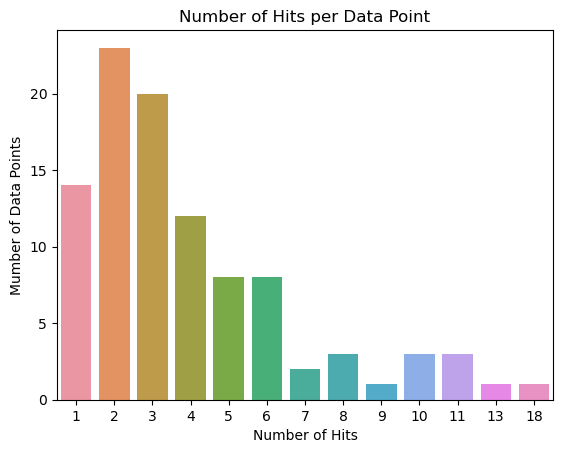

In [988]:
model_data = data[data['numWords'] > 0]

# this removes all data points that have 0 hits, only 1 so the size of the set is not affected much

sns.countplot(data = model_data, x = 'numWords')
plt.title('Number of Hits per Data Point')
plt.ylabel('Mumber of Data Points')
plt.xlabel('Number of Hits');

_There is one data point with no hits, but the majority of data points have somewhere from 1-4 hits._

In [989]:
# testing the format of the texts:

type(data.iloc[0]['paragraphs']) # okay cool its the type we want! Let's run the cleaning on it?

str

In [990]:
# sampling a random data point and getting its paragraphs (text)
sample = data.sample(1)['paragraphs'].values[0] # gives the text of the first data point 
sample_nws = re.sub(pattern = ' ' , repl = '', string = sample) # removes all white spaces 

tokens = np.array([word.surface for word in tagger(sample)]) # turns text string into an array of tokens 
tokens_nws = np.array([word.surface for word in tagger(sample_nws)]) # turns the string with no white space into an array of tokens

tokens_with_lemma = np.array([word.feature.lemma for word in tagger(sample)])
tokens_with_lemma_nws = np.array([word.feature.lemma for word in tagger(sample_nws)])


# uncomment below if you want to see a printed out version of the lemma and tokens 
# if len(tokens) == len(tokens_with_lemma) and len(tokens_nws) == len(tokens_with_lemma_nws):
#     print('there are the same number of tokens:', (len(tokens) == len(tokens_nws)))
#     print('there are more tokens when you remove white spaces :', (len(tokens) < len(tokens_nws)))
#     print('tokens     \tlemma    \ttokens2   \tlemma2')
#     for i in range(min(len(tokens), len(tokens_nws))):
#         print(tokens[i], '\t\t', tokens_with_lemma[i], '\t\t', tokens_nws[i], '\t\t', tokens_with_lemma_nws[i])
        
    
# let's put this into a data frame: 
m = min(len(tokens), len(tokens_nws))
columns = ['tokens','lemma','tokensNws','lemmaNws']

lemma_data = pd.DataFrame(data = {'tokens':tokens[:m], 'lemma':tokens_with_lemma[:m], 'tokensNws':tokens_nws[:m],'lemmaNws':tokens_with_lemma_nws[:m]}) 
        

In [991]:
lemma_data

,tokens,lemma,tokensNws,lemmaNws
0,妩丨,None,妩丨,None
1,丙,丙,丙,丙
2,一千,一千,一千,一千
3,ニ,二,ニ,二
4,第,第,第,第
...,...,...,...,...
6847,千,千,で,で
6848,八百,八百,も,も
6849,〇,零,、,、
6850,八,八,规子,None


In [992]:
# remove stop words, then find lemma ? can you find the lemma of tokens?

In [993]:
# tokens[0].feature.lemma


_If you uncomment the above cell, you will see that token objects are unable to return the lemma version, so you'll have to tokenize the string itself and get the lemma that way. The solution here is create both arrays, clean the non-lemma version, then only take the indexes from the lemma version that pass the cleaning of the non-lemma version_

In [994]:
# make a data frame with the target words in it: 
patterns = (['！', '!','\?','@','#','\$','%','\^','&', '#', '\d+', '[a-zA-Z]+', '〇', '「','」',
             '-','_','№', r'\\','\.','\,','/','~','`','|','〆', "'", '，',
            ':',';','\(', '\)','：','；', '、' , '｜', '»','«','•', "＊", '|', '|']) # these are characters found manually through scanning raw data points

stop_words_data = pd.read_csv('stopwords-ja.txt', sep = ' ', header = None) # these are known japanese stop words

patterns.extend(stop_words_data[0].values)

removal_characters = pd.DataFrame(data = {'character':patterns}) # put the removal characters into a data frame 


In [995]:
# remove the visibly wrong characters: 

def remove_numbers(string):
    '''literally just remove all numbers from a string, we don't want them'''
    cleaned = re.sub(pattern = '\d+', repl = '', string = string)
    return cleaned

def remove_special_characters(string):
    cleaned = string[:] # makes a copy -- don't overwrite the original!
    patterns = removal_characters['character'].values
    for pat in patterns:
        cleaned = re.sub(pattern = pat, repl = '', string = cleaned)
    return cleaned

In [996]:
sample_0 = data.iloc[0]['paragraphs']

remove_special_characters(sample_0)[0:100] # just to see a sample 

'滅念祀迎獸轚鼴罾鐮  帝  世黏レゎ —  こ  於  ヤニル    怒  ざ  牝把  あ  蕾  膽一  十  萬ミ  る  内  世六萬  二世七錢  ぃ体 “       叱  六纪  傭  '

_This looks good for now! (clean enough at least) let's extend this to all the arrays and get analyzing_

_additionally, I'd like to remove all the white spaces, I think this would help remove certain tokens we don't need_


In [997]:
def remove_whitespace(string):
    return re.sub(pattern = ' ', repl = '', string = string)


def clean_string(string):
    temp = remove_special_characters(string)
    temp = remove_numbers(temp)
    temp = remove_whitespace(temp)
    return temp

In [998]:
# cleaning all arrays
tok= model_data['paragraphs'].apply(clean_string).values

new_col = {'cleanText': tok}

model_data = model_data.assign(**new_col)

In [999]:
model_data.head()

,link,linkWithDate,numWords,paragraphs,pdfName,cleanText
0,https://hojishinbun.hoover.org/?a=d&d=jan19360...,https://hojishinbun.hoover.org/en/newspapers/j...,5,滅念祀迎獸轚鼴罾鐮 81 帝 1 世を黏レゎそれ —№ 11 にこ # は於 & しヤやニル...,jan_19360710_0019.pdf,滅念祀迎獸轚鼴罾鐮帝世黏レゎ—こ於ヤニル怒ざ牝把あ蕾膽一十萬ミる内世六萬二世七錢ぃ体“叱六纪...
1,https://hojishinbun.hoover.org/?a=d&d=kam19350...,https://hojishinbun.hoover.org/en/newspapers/k...,7,"「 ，！ 一 ： こ匿 - — 511. :.?-<-€¢€1—""--#118*141( -...",kam_19350811_0003.pdf,"一こ匿—<€¢€—""*戈ザネぶ士人冲七八人迄婦人く結婚一どぅ俘世まぬ一齡モレノ博士發表卜中办..."
2,https://hojishinbun.hoover.org/?a=d&d=kam19420...,https://hojishinbun.hoover.org/en/newspapers/k...,5,一世二世の失業者は ’： 一 1^ ノ至急市協へ報吿せょ一 ：1 - ”£2” 日本人救濟の...,kam_19420128_0003.pdf,一世二世失業者’一ノ至急市協報吿ょ一”£”日本人救濟參矜資料一奶|||？||系||び争靡ダビ...
3,https://hojishinbun.hoover.org/?a=d&d=jan19410...,https://hojishinbun.hoover.org/en/newspapers/j...,6,號ニ十六百七千四万一第 當太和 3 声では開菜一一一却年 2.. ' と I て來る四 ：：...,jan_19410107_0005.pdf,號ニ十六百七千四万一第當太和声開菜一一一却年來る四一日ま人料割引オる親目見る？供見るふ世起紙...
4,https://hojishinbun.hoover.org/?a=d&d=kam19350...,https://hojishinbun.hoover.org/en/newspapers/k...,2,ジブラルタルとスュズ運河 ， 藤丼整 霉とな 〇 先が ^ ブチルタル線杯か 6111 8 ...,kam_19350922_0002.pdf,ジブラルタルスュズ運河藤丼整霉先ブチルタル線杯故こ特航士鑾筘交ぁ厂接万七千ぬむるジブ备嘉£與...


**Note that you can add more special characters to remove later to the patterns array and it should work fine**

In [1000]:
# reduce the size of the matrix to be nearest neighbors to the hit


def make_hit_arrays(string, hit, r):
    '''return a shortened version of STRING that is centered around HIT with R characters on each side of it
    STRING: any string
    HIT: any word
    returns:
    STRING wihout HIT, N: any positive integer that is the location of HIT in STRING. will return the first occurence of the first character of HIT'''
    ns = [] # this means there is no occurence of HIT if empty
    hit_strings = []
    
    if (hit in string): # first see that HIT is actually in STRING to avoid errors
        size_hit = len(hit) # how many characters to examine at once 
        
        for n in range(len(string) - size_hit): # itterate through STRING until you reach HIT
            
            if string[n:n+size_hit] == hit: # iterating till we reach HIT
                ns.append(n)
                hit_strings.append(string[max(0,n - r): min(n + r, len(string))])
    return hit_strings
    


In [1001]:
# testing: and it works!
sample = model_data['cleanText'].sample(1)

make_hit_arrays(sample, hit = '二世', r = 10)

[]

_for verification later, we will want to add a column that gives the index value of the original text so we can verify which version each new data point comes from to test for accuracy_

In [1002]:
np.array([])

np.array([0,0]) + 1

array([1, 1])

In [1003]:
# adding the hits to a new data set to make more data points: 

hit = '二世'
r = 50 # change this as you need to make the text strings longer and shorter 

new_data_points = [] # append this then make an array
data_index = np.array([]) # an array that contains the original index value of the new data points 
c = 0
for s in model_data['cleanText'].values:
    new_strings = make_hit_arrays(s, hit = '二世', r = r)
    data_index = np.append(data_index, np.zeros(len(new_strings)) + c)
    new_data_points.extend(new_strings)
    c += 1

    
    
feature_data = pd.DataFrame(data = {'text': new_data_points})# the final data frame with cleaned arrays with hits at the cetner 

# feature_data.head()


In [1004]:
len(new_data_points), len(data_index)

data_index = [int(i) for i in data_index] # so the index values are ints in the final column 

In [1005]:
# now remove the hit: 

def remove_hit(string, hit):
    if (hit in string): # first see that HIT is actually in STRING to avoid errors
        size_hit = len(hit) # how many characters to examine at once 

    for n in range(len(string) - size_hit): # itterate through STRING until you reach HIT
        if string[n:n+size_hit] == hit: # iterating till we reach HIT
            mod_string = string[0:n] + string[n+size_hit:] # create a modified string without HIT
            return mod_string
        
# test:       
n = np.random.randint(feature_data.size) # picks a random sample data point 
# test
print('Regular text: \t\t',feature_data.iloc[n]['text'])
print('text without hit: \t',remove_hit(feature_data.iloc[n]['text'], hit = hit))

Regular text: 		 必皙一借る？攀霣士行|共痛感時間念割ル—ズぬ米一時間覿ルズ办結果ぅ疋喚起日本少東』京ぬ近峙間獻砍|第二世晃學阒一一行共…|三東京吏局—鈴木生紀以一常ンフ八む射钤各よ石利的省割改ベよナ冬丁二余ト祀费狀郎
text without hit: 	 必皙一借る？攀霣士行|共痛感時間念割ル—ズぬ米一時間覿ルズ办結果ぅ疋喚起日本少東』京ぬ近峙間獻砍|第晃學阒一一行共…|三東京吏局—鈴木生紀以一常ンフ八む射钤各よ石利的省割改ベよナ冬丁二余ト祀费狀郎


In [1006]:
# now cleaning again to get no hit in the string: 

no_hits = feature_data['text'].apply(remove_hit, hit = hit)

feature_data = feature_data.assign(**{'noHit':no_hits})

In [1007]:
# removing single character tokens using these two arrays: 
katakana = (['ア','イ','ウ','エ','オ',
             'カ','キ','ク','ケ','コ',
             'ガ','ギ','グ','ゲ','ゴ',
             'サ','シ','ス','セ','ソ',
             'ザ','ジ','ズ','ゼ','ゾ',
             'タ','チ','ツ','テ','ト',
             'ダ','ヂ','ヅ','デ','ド',
             'ナ','ニ','ヌ','ネ','ノ',
             'ハ','ヒ','フ','ヘ','ホ',
             'パ','ピ','プ','ペ','ポ',
             'バ','ビ','ブ','ベ','ボ',
             'マ','ミ','ム','メ','モ',
             'ヤ','ヨ','ユ',
             'ラ','リ','ル','レ','ロ',
             'ワ','ヲ','ン']) # note I didn't remove the 2 character kana out of laziness 
hiragana = (['あ','い','う','え','お',
             'か','き','く','け','こ',
             'が','ぎ','ぐ','げ','ご',
             'さ','し','す','せ','そ',
             'ざ','じ','ず','ぜ','ぞ',
             'た','ち','つ','て','と',
             'だ','ぢ','づ','で','ど',
             'な','に','ぬ','ね','の',
             'は','ひ','ふ','へ','ほ',
             'ば','び','ぶ','べ','ぼ',
             'ぱ','ぴ','ぷ','ぺ','ぽ',
             'ま','み','む','め','も',
             'や','ゆ','よ',
             'ら','り','る','れ','ろ',
             'わ','を','ん'])

In [1008]:
# now lets see how tokenizing goes: 

def tokenize(string):
    '''given a string STRING, return the tokens in lemma form in the form of a numpy array'''
    tokens = np.array([word.surface for word in tagger(string)]) # store the raw tokens of each token
    return tokens


# supplemental functions I made in post: 

def remove_kana(arr):
    new_arr = []
    for a in arr:
        if a not in katakana and a not in hiragana: 
            new_arr.append(a)
    return new_arr 

def remove_none(arr):
    new_arr = []
    for a in arr:
        if a != None:
            new_arr.append(a)
    return new_arr 


# this turns the string into lemma (and are cleaned for issues found later)
def lemmize(string):
    lemma = np.array([word.feature.lemma for word in tagger(string)])# store the lemma 
    fin_lemma = remove_kana(remove_none(lemma)) # nested functions here 
    return fin_lemma

In [1009]:
tok, lem = feature_data['noHit'].apply(tokenize), feature_data['noHit'].apply(lemmize)

In [1010]:
new_cols = {'tokens': tok, 'lemma': lem}

feature_data = feature_data.assign(**new_cols)

feature_data.head()

,text,noHit,tokens,lemma
0,滅念祀迎獸轚鼴罾鐮帝世黏レゎ—こ於ヤニル怒ざ牝把あ蕾膽一十萬ミる内世六萬二世七錢ぃ体“叱六纪...,滅念祀迎獸轚鼴罾鐮帝世黏レゎ—こ於ヤニル怒ざ牝把あ蕾膽一十萬ミる内世六萬七錢ぃ体“叱六纪傭ゐ...,"[滅, 念, 祀迎, 獸轚, 鼴罾, 鐮帝, 世, 黏, レ, ゎ, —, こ, 於, ヤニ...","[メツ, 念, 世, れる, —, 怒, 座, 雌, 把, あー, 蕾, 十, 万, 内, ..."
1,六纪傭ゐ嫌こヒパ才<ャ—歡祀ヒげ蟓譬る二说す翠づぃ初あゲ後世歡撕少る一あ比二芑坩奶七此處十印...,六纪傭ゐ嫌こヒパ才<ャ—歡祀ヒげ蟓譬る二说す翠づぃ初あゲ後世歡撕少る一あ比二芑坩奶七此處十印...,"[六, 纪傭, ゐ, 嫌, こ, ヒ, パ, 才, <, ャ, —, 歡祀, ヒ, げ, 蟓...","[六, 居る, 嫌, サイ, ＜, —, 気, 二, 為る, 緑, 出る, ぃ, 初, 後世..."
2,ダ命鳩績布讓曹立¢北泠濬南我くサ齡デ—ザ帝牛蒙軍||中離|ゎっ遍艺す££氍纪年ご令装允勢す个...,ダ命鳩績布讓曹立¢北泠濬南我くサ齡デ—ザ帝牛蒙軍||中離|ゎっ遍艺す££氍纪年ご令装允勢す个...,"[ダ, 命, 鳩, 績, 布, 讓, 曹, 立, ¢, 北, 泠濬, 南, 我, く, サ,...","[命, 鳩, イサオ, ヌノ, ユズル, 曹, 立, ¢, 北, 南, デ-des, —, ..."
3,赛纪位奶如和<會ねけ種讒*癢山|||曾入ゎ一大舞雄期以上|仍牧檐鬌こ出來淑晌平康色づ？表齷一...,赛纪位奶如和<會ねけ種讒*癢山|||曾入ゎ一大舞雄期以上|仍牧檐鬌こ出來淑晌平康色づ？表齷一...,"[赛纪, 位, 奶, 如, 和, <, 會, ね, け, 種, 讒, *, 癢山, |, |...","[位, ナイ, ジョ, ＜, 会, 種, 讒, ＊, ｜, ｜, ｜, 曾, 入り, 一大,..."
4,山|||曾入ゎ一大舞雄期以上|仍牧檐鬌こ出來淑晌平康色づ？表齷一び行く第二世|翁一世平均年齡...,山|||曾入ゎ一大舞雄期以上|仍牧檐鬌こ出來淑晌平康色づ？表齷一び行く第|翁一世平均年齡五十...,"[山, |, |, |, 曾, 入, ゎ, 一大, 舞, 雄, 期, 以上, |, 仍, 牧...","[山, ｜, ｜, ｜, 曾, 入り, 一大, マイ, タケシ, 期, 以上, ｜, 猶, ..."


In [1011]:
# nones are no good, so lets keep tokens for now and hope for the best: 

feature_data_v1 = feature_data[['tokens']]
feature_data_v2 = feature_data[['lemma']] # second version of the feature data that only includes the lemma -- will need to remove non-hits 

In [1012]:
feature_data_v1, feature_data_v2

(                                                tokens
 0    [滅, 念, 祀迎, 獸轚, 鼴罾, 鐮帝, 世, 黏, レ, ゎ, —, こ, 於, ヤニ...
 1    [六, 纪傭, ゐ, 嫌, こ, ヒ, パ, 才, <, ャ, —, 歡祀, ヒ, げ, 蟓...
 2    [ダ, 命, 鳩, 績, 布, 讓, 曹, 立, ¢, 北, 泠濬, 南, 我, く, サ,...
 3    [赛纪, 位, 奶, 如, 和, <, 會, ね, け, 種, 讒, *, 癢山, |, |...
 4    [山, |, |, |, 曾, 入, ゎ, 一大, 舞, 雄, 期, 以上, |, 仍, 牧...
 ..                                                 ...
 395  [安, フレッド, 君, スヵラステイツク, 誌, 辦數, 懸賞, 論, 好, 居, 見事,...
 396  [紬, 育, 齓都, 第, こ, 世, 問題, 最, 重要, 案件, 在米, 同胞, 十, ...
 397  [會, 割合, 沒, 交渉, 態度, 執, 居る, 感, 識者, 夙此, 問題, 留, 息,...
 398  [該, 問題, ま, 解, 决途, 發見, 至, す, 紐育, 於ける, 特, 補, 地方,...
 399  [題, 對, 米人, 態度, 門, 戶, 開放, 均等, 機, 會, 與ふる, 如, 系, ...
 
 [400 rows x 1 columns],
                                                  lemma
 0    [メツ, 念, 世, れる, —, 怒, 座, 雌, 把, あー, 蕾, 十, 万, 内, ...
 1    [六, 居る, 嫌, サイ, ＜, —, 気, 二, 為る, 緑, 出る, ぃ, 初, 後世...
 2    [命, 鳩, イサオ, ヌノ, ユズル, 曹, 立, ¢, 北, 南, デ-des, —, ...
 3    [位, ナイ, ジョ, ＜, 会, 種, 讒, ＊, ｜, ｜, ｜, 曾, 入り, 一大,...
 4    [山, ｜, ｜, ｜, 曾,

In [1013]:
# now let's find all the unique tokens

unique_tokens = []
token_counts = {} # empty dictionary 
for tokens in feature_data_v1['tokens']:
    for tok in tokens:
        if tok not in unique_tokens: 
            unique_tokens.append(tok)
            token_counts[tok] = 1
        else:
            token_counts[tok] +=1
            
# now all unique lemma: 

unique_lemma = []
lemma_counts = {} # empty dictionary 
for lemma in feature_data_v2['lemma']:
    for lem in lemma:
        if lem not in unique_lemma: 
            unique_lemma.append(lem)
            lemma_counts[lem] = 1
        else:
            lemma_counts[lem] +=1

print('number of unique tokens: ',len(unique_tokens))
print('number of unique lemma:  ', len(unique_lemma))

number of unique tokens:  7026
number of unique lemma:   3956


In [1014]:
token_df = pd.DataFrame.from_dict(data = token_counts, orient = 'index').rename({0:'Occurences'}, axis = 1)
lemma_df = pd.DataFrame.from_dict(data = lemma_counts, orient = 'index').rename({0:'Occurences'}, axis = 1)

lemma_df.head()

,Occurences
メツ,4
念,10
世,287
れる,69
—,220


In [1015]:
# sns.countplot(data = lemma_df[lemma_df[lemma_df['Occurences'] > 1] < 50], x = 'Occurences')
# plt.xticks(rotation=45)
# plt.title('Frequency of Lemma Across all Data Points')
# plt.xlabel('number of occurences in data')
# plt.ylabel('number of lemma')
# plt.show()

# sns.countplot(data = token_df[token_df[token_df['Occurences'] > 1] < 50], x = 'Occurences')
# plt.xticks(rotation=45)
# plt.title('Frequency of Tokens Across all Data Points')
# plt.xlabel('number of occurences in data')
# plt.ylabel('number of tokens')
# plt.show()

In [1038]:
tixs

array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100.])

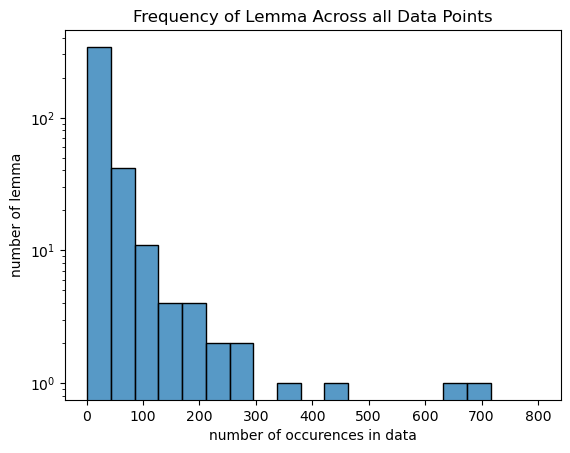

In [1045]:
# now only plotting tokens that appear 10 or more times -- so we can see the distribution better for the higher values

num_lemma = 800
tixs = np.linspace(start = 1, stop = num_lemma, num = 20)

sns.histplot(data = lemma_df, x = 'Occurences', bins = tixs)
# plt.xticks(ticks = tixs, labels = tixs//1)
plt.title('Frequency of Lemma Across all Data Points')
plt.xlabel('number of occurences in data')
plt.ylabel('number of lemma')
plt.yscale('log')
plt.show()


# sns.countplot(data = token_df, x = 'Occurences')
# plt.xticks(ticks = tixs, labels = tixs//1)
# plt.title('Frequency of Tokens Across all Data Points')
# plt.xlabel('number of occurences in data')
# plt.ylabel('number of tokens')
# plt.show()

_If you examine the values in the dictionary, you will see that the majority of the tokens appear only once. this is not useful for analysis, so only including tokens that appear more than once will be more ideal However, if there is a token that appears in all data points, then that is not useful either._

In [1017]:
# so cleaning after looking at it closer: we want occurences that are greater than 10 let's say, 

token_df = token_df[token_df['Occurences'] >= 10]
lemma_df = lemma_df[lemma_df['Occurences'] >= 10]

In [1018]:
token_df.head() # also see how there are still kana here 

,Occurences
念,10
世,287
レ,25
ゎ,17
—,220


In [1019]:
lemma_df.head()   

,Occurences
念,10
世,287
れる,69
—,220
座,29


In [1020]:
lemma_df.describe()

,Occurences
count,410.000000
mean,34.817073
std,62.493056
min,10.000000
25%,12.000000
50%,17.000000
75%,30.000000
max,687.000000


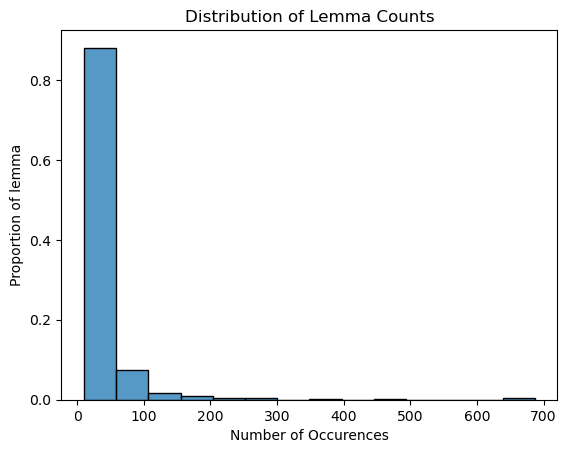

In [1111]:
# now let's see what we have now: 

sns.histplot(data = lemma_df, x = 'Occurences', stat = 'proportion', bins = np.linspace(10,np.max(lemma_df['Occurences'])//1, 15))
plt.title('Distribution of Lemma Counts')
plt.xlabel('Number of Occurences')
plt.ylabel('Proportion of lemma')
plt.show()

## Making the Training Matrix

Create the matrix using One Hot Encoding methods and using the count as the value in the matrix. 
the column labels will be the unique tokens the indexes will be the index of the data points in the feaure data data frame

In [1022]:
feature_data_v2

,lemma
0,"[メツ, 念, 世, れる, —, 怒, 座, 雌, 把, あー, 蕾, 十, 万, 内, ..."
1,"[六, 居る, 嫌, サイ, ＜, —, 気, 二, 為る, 緑, 出る, ぃ, 初, 後世..."
2,"[命, 鳩, イサオ, ヌノ, ユズル, 曹, 立, ¢, 北, 南, デ-des, —, ..."
3,"[位, ナイ, ジョ, ＜, 会, 種, 讒, ＊, ｜, ｜, ｜, 曾, 入り, 一大,..."
4,"[山, ｜, ｜, ｜, 曾, 入り, 一大, マイ, タケシ, 期, 以上, ｜, 猶, ..."
...,...
395,"[安, フレッド-Fred, 君, 誌, 懸賞, 論, 好, 居, 見事, 当, 安, 船,..."
396,"[紬, 育, 第, 小, 世, 問題, 最, 重要, 案件, 在米, 同胞, 十, 余, 万..."
397,"[会, 割合, 交渉, 態度, 居る, 感, 識者, 問題, 止め, 息, 所謂, 在留, ..."
398,"[該, 問題, まー, 解, 発見, 至り, 為る, ニューヨーク, 於ける, 特, 補, ..."


In [1023]:
# feature_data_v2.iloc[0].values[0]

In [1024]:
training_lemma = lemma_df.index # list of the lemma in order from the lemma data frame 

training_lemma

Index(['念', '世', 'れる', '—', '座', '把', 'あー', '十', '万', '内',
       ...
       '学生', '兵', '員', '母', '知', '婚', '盛', '移民', '良', '〕'],
      dtype='object', length=410)

_plan: make a dictionary of each data point where the dictionary contains an array with the count values for each lemma, then add that to a data frame_ 

In [1025]:
data_point_lemma_counts = {} # empty dictionary that will be used to make a data frame
count_lemma = len(training_lemma)
# for i in range(count_lemma):
#     data_point_lemma_counts[i] = [] # set them to empty arrays 

c = 0 # this keeps track of the index value we are on
for dp in feature_data_v2.values: # dp meaning data point 
    # print('first loop:',dp)
    count_array = np.zeros(count_lemma)
    # print('count array:', count_array)
    for d in dp[0]:  # iterate through the individual lemma from the array for each data point 
        # print('\tsecond loop',d)
        for i in range(count_lemma): # this gets the index of the lemma that we can add to the count_lemma array 
            if d == training_lemma[i]:
                # print("\t\tfound hit" ,training_lemma[i])
                count_array[i] += 1
                # print('changed array: ', count_array)
    data_point_lemma_counts[c] = count_array
    c += 1
            

In [1026]:
theta_matrix = pd.DataFrame.from_dict(data = data_point_lemma_counts, orient = 'index', columns = training_lemma)

In [1027]:
theta_matrix.head(-5)

,念,世,れる,—,座,把,あー,十,万,内,...,学生,兵,員,母,知,婚,盛,移民,良,〕
0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
391,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1028]:
theta_matrix.describe()

,念,世,れる,—,座,把,あー,十,万,内,...,学生,兵,員,母,知,婚,盛,移民,良,〕
count,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,400.00000,400.000000,400.000000,400.00000,...,400.000000,400.000000,400.00000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,0.02500,0.717500,0.172500,0.550000,0.07250,0.075000,0.20250,0.260000,0.082500,0.02500,...,0.032500,0.027500,0.03500,0.04250,0.032500,0.032500,0.025000,0.045000,0.025000,0.03500
std,0.15632,0.916402,0.422125,0.932563,0.31223,0.299331,0.47651,0.541417,0.309731,0.15632,...,0.215778,0.204569,0.19716,0.20198,0.203832,0.215778,0.171606,0.261047,0.171606,0.28102
min,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.00000,1.000000,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.00000,6.000000,2.000000,6.000000,2.00000,2.000000,3.00000,3.000000,2.000000,1.00000,...,2.000000,2.000000,2.00000,1.00000,2.000000,2.000000,2.000000,3.000000,2.000000,4.00000


In [1029]:
theta_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Columns: 410 entries, 念 to 〕
dtypes: float64(410)
memory usage: 1.3 MB


_AHAHHA!!! Yes this is exactly what we want! This is a training matrix that we can use to figure out clustering (hopefully) !!_

## Determining Best Parameters

To do this, we will use PCA analysis to find the tokens with the most variance, this will give us the largest spread of values in our differnet data points and will make clustering the most effective. Imagine if _**all**_ data points had the same value for a given token, you would learn nothing about the differences between these to cluster, so that would be a zero variance parameters. the most variance tells us the most about the characteristics we want to differentiate to make our clusters

This will be done in a separate notebook, so we just need to export our theta matrix to our URAP folder

In [1030]:
# exporting the matrix: 

# Specify the folder and file name
folder_path = 'C:\\Users\\alica\\Documents\\URAP\\URAP_NLP'
file_name = 'nisei_matrix.csv'

# Export the DataFrame to CSV
theta_matrix.to_csv(folder_path + file_name, index=False)

In [1031]:
# exporting the matrix 

from pathlib import Path  
filepath = Path('C:\\Users\\alica\\Documents\\URAP\\URAP_NLP\\nisei_matrix.csv')    # set this to whatever path you want, 
                                                                                    # but the name of the csv should be unchanged
filepath.parent.mkdir(parents=True, exist_ok=True)  # makes a directory for the CSV file to be written into 
theta_matrix.to_csv(filepath)   



In [1032]:
# now export the second matrix that gives the orignal index value (wasn't needed for training purposes)

index_matrix = theta_matrix.assign(**{'originalIndex': data_index})

filepath = Path('C:\\Users\\alica\\Documents\\URAP\\URAP_NLP\\nisei_w_index_matrix.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  # makes a directory for the CSV file to be written into 
index_matrix.to_csv(filepath) 

## Possible additions: 

1. add a weight to the values so there is an accounting of distance from the target word, so we can account for closer tokens being more descriptive of the usage of our target word. Requires some sort of normalization. 
2. Creating a sliding scale from -1 to 1 for categorization. 
3. keep track of the years of these occurences to see usage over time -- can be a separate matrix that we can scatter plot once we have a clustering 

In [1102]:
# making data table to send to Prof Leong

urap_table = feature_data[['text']].assign(**{'originalIndex':data_index})
tempdf = data.join(urap_table).drop(99, axis = 0).drop(['numWords', 'linkWithDate'], axis = 1)

In [1106]:
new_col_order = ['link','pdfName','originalIndex','paragraphs','text']
tempdf = tempdf[new_col_order]

tempdf = tempdf.rename(columns = {'paragraphs': 'original text', 'text':'cleaned text'})

In [1107]:
# kay let's export 

filepath = Path('C:\\Users\\alica\\Documents\\URAP\\URAP_NLP\\verification_table.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  # makes a directory for the CSV file to be written into 
tempdf.to_csv(filepath) 